# Alternating minimization
Reconstruction with alternating minimization (possible using both strobed illumination for initializations)

In [5]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import scipy.misc as misc
import matplotlib.pyplot as plt
import time
import sys
import itertools
import scipy.io as sio
import datetime
import os, glob

# MD imports
from libwallerlab.opticsalgorithms.motiondeblur import blurkernel
from libwallerlab.opticsalgorithms.motiondeblur import kernel_objectives
from libwallerlab.opticsalgorithms.motiondeblur import blurkernelplot as bkplt

# Libwallerlab imports
import libwallerlab.operators as ops
import libwallerlab.operators.base as bops
from libwallerlab.utilities import opticstools, displaytools, iotools
from libwallerlab.algorithms import iterative, objectivefunctions, regularizers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
ops.setDefaultBackend('numpy') # arrayfire or numpy
ops.setDefaultDatatype('complex64')

global_dtype = ops.config.default_dtype
global_backend = ops.config.default_backend
np_dtype = bops.getNativeDatatype(ops.config.default_dtype, ops.config.default_backend)

## Load Data

Skipping unknown key port
Skipping unknown key filename
Loaded dataset: res_target_color_coded_raster_motiondeblur_2018_05_22_19_17_45


<IPython.core.display.Javascript object>


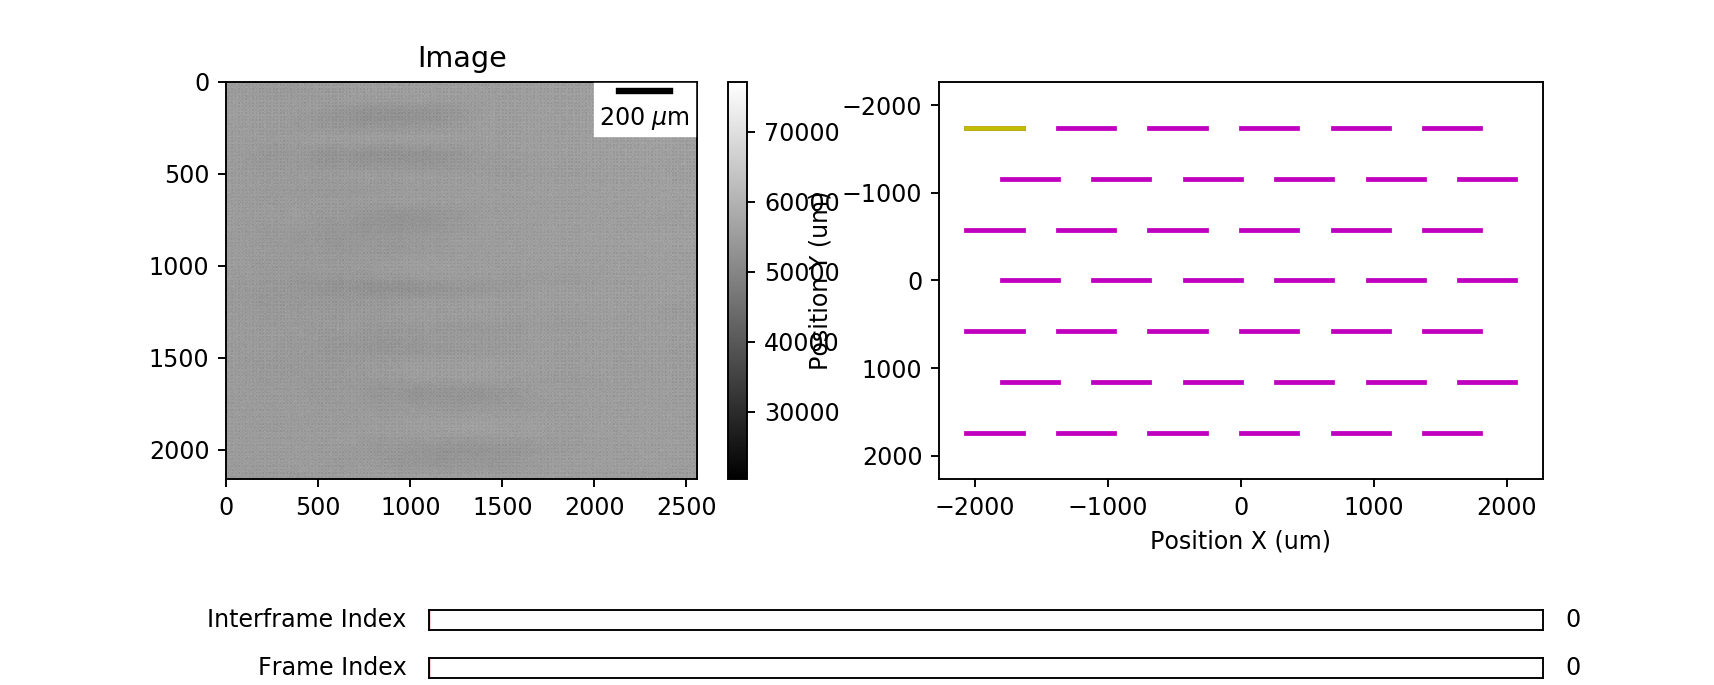

(<matplotlib.figure.Figure at 0x7f2684056be0>,
 <function libwallerlab.utilities.iotools.Dataset.show.<locals>.frame_update_function_handle>,
 <function libwallerlab.utilities.iotools.Dataset.show.<locals>.interframe_update_function_handle>)

In [7]:
dataset_path_stem = '/Users/zfphil/Dropbox/Datasets/motiondeblur_datasets/'
dataset_path_stem = 'D:\\Zack\\Dropbox\\Datasets\\motiondeblur_datasets\\'
dataset_path_stem = 'D:\\Zack\\05-22-18-MotionDeblur\\'
dataset_path_stem = '/Users/zfphil/Desktop/'
dataset_path_stem = 'J:\\data\\'
dataset_path_stem = '/home/sarah/Dropbox/motiondeblur_datasets/'

# dataset_path_stem = 'J:/Dropbox/Datasets/motiondeblur_datasets/'

dataset_path = 'res_target_color_coded_raster_motiondeblur_2018_05_22_19_17_45' # Good dataset
# dataset_path = 'res_target_color_strobe_raster_motiondeblur_2018_05_22_19_17_18'

dataset = iotools.Dataset(dataset_path=dataset_path_stem + dataset_path)

# Expand metadata if necessary
dataset.show('position')

In [10]:
# TODO

# dataset_path_strobed =  dataset_stem+'MD-3-15-18/USAF_strobe_motiondeblur_2018_03_15_19_30_51'
# dataset_strobed = iotools.Dataset(dataset_path=dataset_path_strobed)
# dataset_strobed.show('position')

## Processing
Demosaic Frames, subtract background, select linear subsegment

In [11]:
if dataset.metadata.camera.is_color:
    color_channel = 0
    frame_list_new = np.zeros((len(dataset.frame_list), 
                               int(dataset.frame_list[0].shape[0]/2), int(dataset.frame_list[0].shape[1]/2)),
                               dtype=np.float)
    for index, frame in enumerate(dataset.frame_list):
        frame_list_new[index,:,:] = displaytools.demosaicFrameDeconv(frame)[:,:,color_channel]

    dataset.frame_list = frame_list_new
    
dataset.subtractBackground()

linear_segment_index = 3
frame_indicies_to_process = []
total_frame_count = len(dataset.frame_list)
for index, frame_state in enumerate(dataset.frame_state_list):
    if frame_state['position']['common']['linear_segment_index'] == linear_segment_index:
        frame_indicies_to_process.append(index)
        
dataset.frame_list = dataset.frame_list[frame_indicies_to_process,:,:]
dataset.frame_state_list = [dataset.frame_state_list[i] for i in frame_indicies_to_process]
print('Segment %d covers %d of %d frames.' % (linear_segment_index, len(frame_indicies_to_process), total_frame_count))

Metadata indicates background has already been subtracted.
Segment 3 covers 6 of 6 frames.


## Generate Blur Kernels from Metadata
This function should return 4 things:
- object size: the full size of the object
- image size: the size of individual images
- blur_kernel_list: the cropped blur kernels (to their own support)
- crop_roi_list: roi's which indicate where the blur kernel should be placed

Image size is 540 x 640, Object size is 541 x 6072, Blur kernel size is 541 x 952
Processed kernel 0 of 6
Processed kernel 1 of 6
Processed kernel 2 of 6
Processed kernel 3 of 6
Processed kernel 4 of 6
Processed kernel 5 of 6


<IPython.core.display.Javascript object>


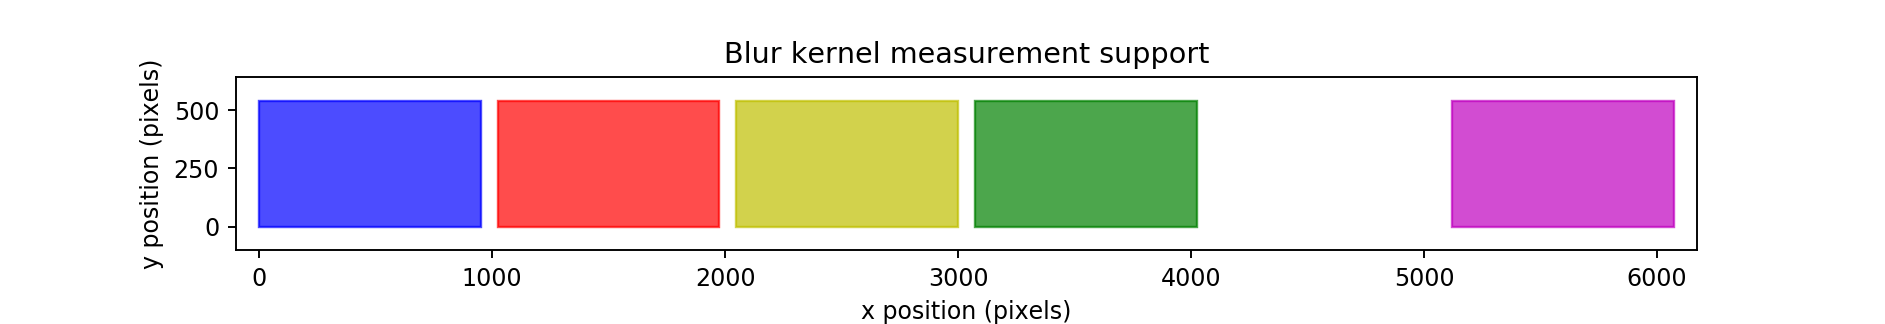

In [12]:
# Get blur_kernel_list, object_size, and image_size
blurkernel_info = blurkernel.blurKernelsFromDataset(dataset, flip_illumination_sequence=False, 
                                                    flip_kernel_y = True, debug=False, 
                                                    use_phase_ramp=False, return_positions=True)
object_size, image_size, blur_kernel_list_color, blur_kernel_roi_list, position_list, illum_list = blurkernel_info

blur_kernel_roi_list = list(reversed(blur_kernel_roi_list))
# Sum the color channels of all blur kernels (TEMPORARY)
blur_kernel_list = []
for index, blur_kernel in enumerate(blur_kernel_list_color):
    first_channel = list(blur_kernel.keys())[0]
    new_kernel = np.zeros(blur_kernel_roi_list[index].size(), dtype=blur_kernel[first_channel].dtype)
    illum = illum_list[index]
    for channel in blur_kernel:
        new_kernel += blur_kernel[channel]
    blur_kernel_list.append(new_kernel)
    
# Plot measurement support
bkplt.plotBlurKernelSupport(blur_kernel_roi_list)

# # displaytools.show3dArray(blur_kernel_list, figsize=(10,8))
# plt.figure(figsize=(9,7))
# plt.imshow(np.abs(blur_kernel_list[0]))

In [11]:
np.power(image_size, 2)

array([1166400, 1638400])

In [12]:
print(len(position_list[0]))

629


In [13]:
print(len(illum_list[0]))

629


# Single Frame Recovery

In [14]:
# Options
frame_index = 3
omit_inner_ft = False

In [32]:
# get illumination and positions
illuminations = illum_list[frame_index]
positions = position_list[frame_index]
illums = []; pos_y = []; pos_x = []
for illum, pos in zip(illuminations,positions):
    if illum[0] > 0:
        illums.append(illum[0])
        pos_y.append(pos[0][0])
        pos_x.append(pos[0][1])

n_illum = len(illums)

In [30]:
# get basis functions for path
n_basis_splines = [4,4]

spl_y = blurkernel.get_basis_splines(n_illum, n_basis_splines[0])
spl_x = blurkernel.get_basis_splines(n_illum, n_basis_splines[1])

w_y = blurkernel.positions_to_splines(spl_y, pos_y)
w_x = blurkernel.positions_to_splines(spl_x, pos_x)
weights_recorded = np.hstack([w_y, w_x])


<IPython.core.display.Javascript object>


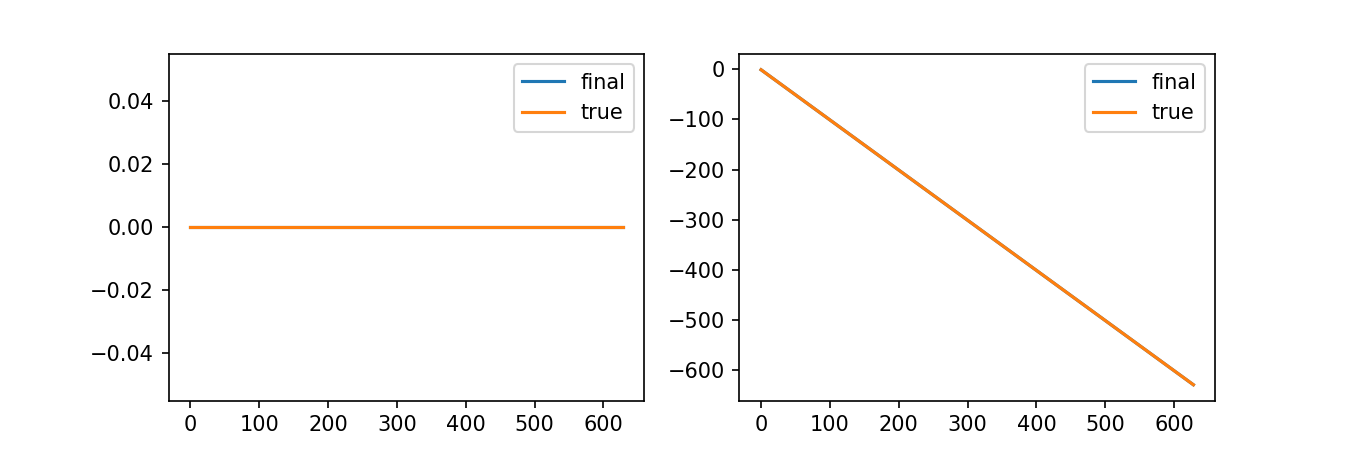

In [31]:
# the x path is not smooth -- hard to fit spline
# TODO: fix x positions?
yhat = spl_y.dot(w_y)
xhat = spl_x.dot(w_x)

plt.figure(figsize=(9,3)); plt.subplot(1,2,1)
plt.plot(yhat, label='final'); 
plt.plot(pos_y, label = 'true'); plt.legend()

plt.subplot(1,2,2); plt.plot(xhat, label='final'); 
plt.plot(pos_x, label = 'true'); plt.legend()

In [21]:
# Get measurement and normalize
y = dataset.frame_list[frame_index][dataset.metadata.camera.roi.y_start:dataset.metadata.camera.roi.y_end,
                                    dataset.metadata.camera.roi.x_start:dataset.metadata.camera.roi.x_end].copy()
y_mean = np.mean(y)
y = bops.changeBackend(bops.astype(y / y_mean, global_dtype), global_backend)
image_size = y.shape

In [26]:
weights_initial = (weights_recorded+np.random.uniform(size=weights_recorded.shape, high=1, low=-1)).astype(np_dtype)
weights_initial = np.expand_dims(weights_initial,1)

object_initial = np.ones(image_size).astype(np_dtype)
object_initial = object_initial / np.sum(object_initial)

objectives, update_fns = blurkernel.getAutocalibrationFns(y, image_size, illums, \
                                                          spl_y, spl_x, weights_initial, object_initial,
                                                         dtype=global_dtype, backend=global_backend,
                                                         verbose=True)
    
its_per_step = [1,1]
step_sizes = [1/np.prod(image_size),1/np.prod(image_size)]
#step_sizes = [None, None]
initializations=[object_initial, weights_initial.copy()]



generating BlurKernelBasis operator
defining diagonalized components
forward with position: (0.780524463799+0j) (13.3776240645+0j)
defining forward models
defining objectives


In [23]:
objectives[0].gradient(object_initial)

array([[-19064.56983521-1.06096209j, -19065.20303446-1.5701082j ,
        -19104.55713095-1.5723406j , ..., -19058.85521634-1.82970231j,
        -19025.95200243-0.87272599j, -19067.29321539-2.04327839j],
       [-22407.93332886+2.86172275j, -22458.89987920-0.23065247j,
        -22422.73829310+3.37310126j, ..., -22397.17059397+0.02894165j,
        -22389.61245854+2.67348666j, -22415.24188151+0.24251773j],
       [-21384.77738004-1.27105269j, -21383.99874988-1.3600176j ,
        -21414.82836108-1.7824312j , ..., -21344.74847534-1.61961171j,
        -21359.40742266-1.0828166j , -21368.83250513-1.83318779j],
       ..., 
       [-13174.05880390+1.98454733j, -13228.38746803+0.64652296j,
        -13236.32514316+2.49592584j, ..., -13153.47777970+0.90611707j,
        -13143.89041830+1.79631124j, -13216.46369063+1.11969315j],
       [-13747.83860848-1.55620904j, -13733.38150232-1.07486125j,
        -13810.49782228-2.06758755j, ..., -13703.16300613-1.33445536j,
        -13687.37846100-1.36797295

In [24]:
objectives[1].gradient(weights_initial)

0.601990857805 311.813450219 127.0
computing over t
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 
constructing columns
0 1 2 3 

forward with position: (0.0676513169338+0j) (13.4936249553+0j)


array([[ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j]])

In [27]:

object_recovered, weights_recovered = iterative.AlternatingGradient(objectives, update_fns, its_per_step, 
                                                                  step_sizes=step_sizes, verbose=True,
                                                                  initializations=initializations,
                                                                  total_it=250)

Minimizing funtion:


<IPython.core.display.Latex object>

beginning iteration with [[  7.23379630e-07+0.j   7.23379630e-07+0.j   7.23379630e-07+0.j ...,
    7.23379630e-07+0.j   7.23379630e-07+0.j   7.23379630e-07+0.j]
 [  7.23379630e-07+0.j   7.23379630e-07+0.j   7.23379630e-07+0.j ...,
    7.23379630e-07+0.j   7.23379630e-07+0.j   7.23379630e-07+0.j]
 [  7.23379630e-07+0.j   7.23379630e-07+0.j   7.23379630e-07+0.j ...,
    7.23379630e-07+0.j   7.23379630e-07+0.j   7.23379630e-07+0.j]
 ..., 
 [  7.23379630e-07+0.j   7.23379630e-07+0.j   7.23379630e-07+0.j ...,
    7.23379630e-07+0.j   7.23379630e-07+0.j   7.23379630e-07+0.j]
 [  7.23379630e-07+0.j   7.23379630e-07+0.j   7.23379630e-07+0.j ...,
    7.23379630e-07+0.j   7.23379630e-07+0.j   7.23379630e-07+0.j]
 [  7.23379630e-07+0.j   7.23379630e-07+0.j   7.23379630e-07+0.j ...,
    7.23379630e-07+0.j   7.23379630e-07+0.j   7.23379630e-07+0.j]]
7.2337962963e-07
computing the gradient
gradient is size 24836.8279935
taking a gradient step
finished performing iteration
now have [[ 0.01601199 -1.0

<IPython.core.display.Latex object>

beginning iteration with [[  7.80524464e-01+0.j]
 [  1.70957044e-01+0.j]
 [  3.38859419e-01+0.j]
 [ -2.23137531e-01+0.j]
 [  1.33776241e+01+0.j]
 [ -1.30906135e+02+0.j]
 [ -2.10704246e+02+0.j]
 [ -3.12296537e+02+0.j]]
7.2337962963e-07
computing the gradient
0.780524463799 312.296537357 127.0
computing over t
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 
constructing columns
0 1 2 3 

forward with position: (0.780524463799+0j) (13.3776240645+0j)
gradient is size 1.95162788993e+12
taking a gradient step
finished performing iter

/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/base.py:294: RuntimeWarning: overflow encountered in cos
  return np.cos(x)
/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/base.py:306: RuntimeWarning: overflow encountered in sin
  return np.sin(x)
/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1696: RuntimeWarning: invalid value encountered in multiply
  result = illum * (cos(inner) + 1j * sin(inner))
/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1696: RuntimeWarning: overflow encountered in add
  result = illum * (cos(inner) + 1j * sin(inner))
/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1696: RuntimeWarning: invalid value encountered in add
  result = illum * (cos(inner) + 1j * sin(inner))
/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1696: RuntimeWarning: overflow encountered in multiply
  result = illum * (cos(inner)

[[-1089331.65232779+740.43638514j]
 [ -368782.05094279+915.51963958j]
 [  490421.57420303+919.69554697j]
 [  967693.19627094+764.02186976j]
 [ 1411781.23781716  +1.23578451j]
 [  448184.83329047  +4.64594399j]
 [ -491857.47173897  +3.69279146j]
 [-1368749.12866256  +4.06465229j]]
forward with position: (967693.196271+764.021869761j) (1411781.23782+1.23578451406j)
forward with position: (967693.196271+764.021869761j) (1411781.23782+1.23578451406j)
updated x2, objective [[ nan+0.j]]
beginning iteration with [[ 0.01601199 -1.03548343e-06j  0.01603920 +9.89956461e-07j
   0.01603370 -1.29017555e-06j ...,  0.01601181 +1.01952094e-06j
   0.01599522 -9.86454286e-07j  0.01602304 +7.93621448e-07j]
 [ 0.01553037 -6.76529631e-07j  0.01556188 +7.22056597e-07j
   0.01555045 -4.21837504e-07j ...,  0.01552076 +6.92492119e-07j
   0.01551424 -7.25558771e-07j  0.01554208 +9.18391609e-07j]
 [ 0.01589677 -3.76609446e-07j  0.01590608 +3.31082480e-07j
   0.01592182 -6.31301573e-07j ...,  0.01587997 +3.606469

/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/base.py:221: RuntimeWarning: overflow encountered in absolute
  return np.abs(x)


gradient is size nan
taking a gradient step
finished performing iteration
now have [[ nan+nanj  nan+nanj  nan+nanj ...,  nan+nanj  nan+nanj  nan+nanj]
 [ nan+nanj  nan+nanj  nan+nanj ...,  nan+nanj  nan+nanj  nan+nanj]
 [ nan+nanj  nan+nanj  nan+nanj ...,  nan+nanj  nan+nanj  nan+nanj]
 ..., 
 [ nan+nanj  nan+nanj  nan+nanj ...,  nan+nanj  nan+nanj  nan+nanj]
 [ nan+nanj  nan+nanj  nan+nanj ...,  nan+nanj  nan+nanj  nan+nanj]
 [ nan+nanj  nan+nanj  nan+nanj ...,  nan+nanj  nan+nanj  nan+nanj]]
computing the cost in iterative
updated x1, objective [[ nan+0.j]]
beginning iteration with [[-1089331.65232779+740.43638514j]
 [ -368782.05094279+915.51963958j]
 [  490421.57420303+919.69554697j]
 [  967693.19627094+764.02186976j]
 [ 1411781.23781716  +1.23578451j]
 [  448184.83329047  +4.64594399j]
 [ -491857.47173897  +3.69279146j]
 [-1368749.12866256  +4.06465229j]]
7.2337962963e-07
computing the gradient
1089331.90397 1411781.23782 127.0
computing over t
0 

/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1717: RuntimeWarning: invalid value encountered in multiply
  if i < self.ndim_y: sum_exp_y[i,:,:] += self.basis_y[t, i] * forward_t
/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1718: RuntimeWarning: invalid value encountered in multiply
  if i < self.ndim_x: sum_exp_x[i,:,:] += self.basis_x[t, i] * forward_t


1 

/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1717: RuntimeWarning: overflow encountered in add
  if i < self.ndim_y: sum_exp_y[i,:,:] += self.basis_y[t, i] * forward_t
/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1717: RuntimeWarning: invalid value encountered in add
  if i < self.ndim_y: sum_exp_y[i,:,:] += self.basis_y[t, i] * forward_t
/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1718: RuntimeWarning: overflow encountered in add
  if i < self.ndim_x: sum_exp_x[i,:,:] += self.basis_x[t, i] * forward_t
/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1718: RuntimeWarning: invalid value encountered in add
  if i < self.ndim_x: sum_exp_x[i,:,:] += self.basis_x[t, i] * forward_t


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 
constructing columns
0 1 2 

/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1724: RuntimeWarning: invalid value encountered in multiply
  if i < self.ndim_y: column_list_y.append(S * Diagonalize(conj(1j * self.ry) * conj(sum_exp_y[i])))
/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1725: RuntimeWarning: overflow encountered in multiply
  if i < self.ndim_x: column_list_x.append(S * Diagonalize(conj(1j * self.rx) * conj(sum_exp_x[i])))
/home/sarah/deblurring/libwallerlab/python/libwallerlab/operators/operators.py:1725: RuntimeWarning: invalid value encountered in multiply
  if i < self.ndim_x: column_list_x.append(S * Diagonalize(conj(1j * self.rx) * conj(sum_exp_x[i])))


3 

forward with position: (967693.196271+764.021869761j) (1411781.23782+1.23578451406j)


KeyboardInterrupt: 

In [ ]:
# Get blur kernel and support
blur_kernel = bops.changeBackend(bops.astype(blur_kernel_list[frame_index], global_dtype), global_backend)
blur_kernel /= bops.scalar(bops.sumb(blur_kernel))
kernel_support_roi = blur_kernel_roi_list[frame_index]

# Store sizes
measurement_size = bops.shape(y)
kernel_size = kernel_support_roi.size()


In [ ]:




# Generate pad operator for image support -> measurement
R0 = ops.Crop(kernel_size, measurement_size, dtype=global_dtype, backend=global_backend, pad_value='reflect')

# Create F.T. operator
F = ops.FourierTransform(kernel_size, dtype=global_dtype, backend=global_backend, normalize=True, center=True, pad=True)

# Diagonalize padded kernel
K = ops.Diagonalize(F * blur_kernel)

# Make forward model (sans outer Fourier Transform)
A = R0 * F.H * K * F

# Initialization: choosing a "good" initial value will help in convergence
initialization = bops.ones(A.N, global_dtype, global_backend)

# Define Objective Function
objective = objectivefunctions.L2(A, y)

# Define Regularizer
# regularizer = 10e-9 * ops.L2Norm(kernel_size)
regularizer = 1e-6 * ops.L1Norm(kernel_size) * ops.FourierTransform(kernel_size)
#regularizer = 1e-6 * regularizers.WaveletSparsity(kernel_size, wavelet_type='db4', extention_mode='symmetric', level=None, use_cycle_spinning=True, axes=None)

# Define Cost Function
cost_function = objective + regularizer

# FISTA implementation
# Note that if objective function is smooth, this is just gradient descent with nesterov acceleration
iteration_count = 50
object_recovered = iterative.Fista(cost_function).solve(initialization=initialization, 
                                                              step_size=1e6,
                                                              nesterov_enabled=True,
                                                              iteration_count=iteration_count, 
                                                              display_type='text', 
                                                              display_iteration_delta=max((iteration_count // 10),1))


In [ ]:
object_recovered_crop = object_recovered
# y = R0.H * R0 * y
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(np.abs(bops.changeBackend(y, 'numpy')), cmap='gray')
plt.colorbar()
plt.title('Raw Data')
plt.subplot(132)
plt.imshow(np.abs(bops.changeBackend(object_recovered_crop, 'numpy')), cmap='gray')
plt.title('Reconstruction')
plt.colorbar()
plt.subplot(133)
plt.imshow(np.abs(bops.changeBackend(A * object_recovered_crop, 'numpy')), cmap='gray')
plt.title('Forward propagation of Recon')
plt.colorbar()

In [ ]:
# Determine ROI

#x_start=1000, x_end=1500, y_start=500, y_end=750
dataset.metadata.camera.roi = iotools.Roi(x_start=500, x_end=1500, y_start=500, y_end=1500)
vmax=np.mean(dataset.frame_list[0]) + 4*np.std(dataset.frame_list[0])
frame_index = 3
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(dataset.frame_list[frame_index], cmap='gray', vmax=vmax)
plt.subplot(122)
roi_image = dataset.frame_list[frame_index][dataset.metadata.camera.roi.y_start:dataset.metadata.camera.roi.y_end,
                                     dataset.metadata.camera.roi.x_start:dataset.metadata.camera.roi.x_end]
plt.imshow(roi_image,cmap='gray', vmax=vmax)


In [ ]:
# same ROI for the strobed data -- comparison

#x_start=1000, x_end=1500, y_start=500, y_end=750
dataset_strobed.metadata.camera.roi = iotools.Roi(x_start=500, x_end=1500, y_start=500, y_end=1500)
vmax=np.mean(dataset.frame_list[0]) + 4*np.std(dataset_strobed.frame_list[0])
frame_index = 3
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(dataset_strobed.frame_list[frame_index], cmap='gray', vmax=vmax)
plt.subplot(122)
roi_image_strobe = dataset_strobed.frame_list[frame_index][dataset.metadata.camera.roi.y_start:dataset.metadata.camera.roi.y_end,
                                     dataset.metadata.camera.roi.x_start:dataset.metadata.camera.roi.x_end]
plt.imshow(roi_image_strobe,cmap='gray', vmax=vmax)


# Initializing the Autocalibration Problem

## Reading the recorded blur kernels

In [ ]:

# Generate Blur Kernels from Metadata
(object_size, image_size_blur_kernel, _, position_list, illum_list) = blurkernel.blurKernelsFromDataset(dataset, 
                                                                                      debug=False, 
                                                                                      use_phase_ramp=False,
                                                                                      return_positions = True)


## Independent points Alternating Min

todo: need to make work for multiframe as well

In [ ]:
# TODO got rid of this method
illuminations, shifts = blurkernel.formatIllumShift(position_list, illum_list, [frame_index], roi_image.shape)

In [ ]:
y = roi_image
y = y.reshape(-1).astype(np.complex64)
y /= np.mean(y)

objectives, setting_fns, initialization, fh_ops = \
                                blurkernel.constructAlternatingMin(illuminations, shifts, roi_image.shape, 1, y)

In [ ]:
O = fh_ops[1]
O.latex()

In [ ]:
objective_object, objective_shift = objectives
A_object_set_shift, A_shift_set_object = setting_fns
obj, shifts = initialization

object_recon, shift_recon = iterative.AlternatingGradient([objective_object, objective_shift], 
                                                          [A_object_set_shift, A_shift_set_object], [2,1],
                                                          initializations = [obj.reshape(-1), shifts], total_it=1)

In [ ]:
object_recon

In [ ]:
image_size = roi_image.shape
F, Hfull = fh_ops

plt.figure(figsize=(10,5))
plt.subplot(221)
plt.imshow(np.abs(object_recon).reshape(image_size), cmap='gray')
plt.title('Recovered Object')

h_est = F.H * Hfull * shifts
plt.subplot(224)
plt.imshow((np.abs((h_est).reshape(image_size))), cmap='gray')
plt.title('Initial PSF')

h_est = F.H * Hfull * shift_recon
plt.subplot(222)
plt.imshow((np.abs((h_est).reshape(image_size))), cmap='gray')
plt.title('Recovered PSF')




## Smooth path optimization

TODO: implement as operators

In [ ]:
pos_parameter = recorded_shifts[:,1]  # to do: this could change

def get_points_from_pos_param(pos_parameter, poly):
    points_x = pos_parameter  # to do: this could change
    points_y = [poly.evaluate(t) for t in pos_parameter]
    return np.vstack([points_y, points_x]).T.flatten()
    


# polynomial class as a stand in smooth function
class polynomial:
    
    def __init__(self, coeffs, offsets):
        self.dim = len(offsets)
        assert len(coeffs) == self.dim + 1, 'incorrect number of parameters'
        self.coeffs = coeffs
        self.offsets = offsets
        
    def evaluate(self, t):
        result = self.coeffs[0]
        for i in range(0, self.dim):
            result = result + self.coeffs[i+1] * (t - self.offsets[i])**(i+1)
        return result
    
    def parameter_grad(self, t): # y gradient
        # omitting gradient for first position -- keep fixed for now
        coeff_grad = [(t - self.offsets[i])**(i+1) for i in range(self.dim)] 
        offset_grad = [- (i+1) * self.coeffs[i+1] * (t - self.offsets[i])**(i) for i in range(self.dim)]
        return np.hstack([coeff_grad, offset_grad])
    
    def update_coeffs(self, coeffs):
        assert len(coeffs) == len(self.coeffs), 'incorrect coeffs size'
        self.coeffs = coeffs
        
    def update_offsets(self, offsets):
        assert len(offsets) == len(self.offsets), 'incorrect offsets size'
        self.offsets = offsets
        
        


In [ ]:
H = ops.PhaseRamp(image_size)
def grad_H(x, i):
    grad_y = H.grid[0] * np.exp((H.grid[0] * x[0] + H.grid[1] * x[1]))
    grad_x = H.grid[1] * np.exp((H.grid[0] * x[0] + H.grid[1] * x[1]))
    return np.vstack([grad_y, grad_x])

In [ ]:
# initializing straight line path
deg_poly = 3
coeffs_init = np.zeros(deg_poly)
offsets_init = np.zeros(deg_poly-1)

coeffs_init[0] = recorded_shifts[0,0]
coeffs_init[1] = pos_extent[0]

initial_path = polynomial(coeffs_init, offsets_init)

# initializing operators for gradient

F = ops.FourierTransform(image_size, normalize=True)

L2 = ops.L2Norm(image_size[0] * image_size[1], dtype=np.complex64)


y = roi_image
y = y.reshape(-1).astype(np.complex64)
y /= np.mean(y)



def A_set_object(obj):
    D_object = ops.Diagonalize((F * obj.reshape(-1)).reshape(image_size), label='Dobject')
    A_shift = F.H * D_object * Hfull
    return A_shift, D_object

def A_set_shift(shifts):
    D_shift = ops.Diagonalize((Hfull * shifts).reshape(image_size), label='Dshift')
    A_object = F.H * D_shift * F
    return A_object

def analytic_gradient(x, A_shift, D_object):
    inner = A_shift(x) - y
    inner_op = (D_object.H * F * inner)
    
    gradients = []
    for i in range(len(illums)):
        gradH = illums[i] * grad_H(x[2*i:2*i+1+1], i)
        E_y = np.dot(np.conj(gradH[0]), inner_op)
        E_x = np.dot(np.conj(gradH[1]), inner_op)
        gradients.append(np.array([E_y, E_x]))
        
    return np.real(np.hstack(gradients))

def analytic_gradient_smooth_curve(poly, A_shift, D_object):
    x = get_points_from_pos_param(pos_parameter, poly).astype(np.complex64)
    grad_wrt_pos = analytic_gradient(x, A_shift, D_object)
    
    grad_p_wrt_t = []
    for t in pos_parameter:
        grad_p_wrt_t.append(poly.parameter_grad(t))
        grad_p_wrt_t.append(np.zeros(grad_p_wrt_t[-1].shape)) # for x positions
    return np.real(np.array(grad_p_wrt_t).T.dot(grad_wrt_pos))
    
    
def analytic_gradient_only_horz(x, A_shift, D_object):
    inner = A_shift(x) - y
    inner_op = (D_object.H * F * inner)
    
    gradients = []
    for i in range(len(illums)):
        gradH = illums[i] * grad_H(x[2*i:2*i+1+1], i)
        E_y = 0
        E_x = np.dot(np.conj(gradH[1]), inner_op)
        gradients.append(np.array([E_y, E_x]))
        
    return np.real(np.hstack(gradients))


In [ ]:
obj = np.ones(roi_image.shape).reshape(-1).astype(np.complex64)

path = polynomial(coeffs_init.copy(), offsets_init.copy())


h_est = F.H * Hfull * get_points_from_pos_param(pos_parameter, path).astype(np.complex64)

# Show object and psf
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(np.abs(obj).reshape(image_size), cmap='gray')
plt.title('Initial Object')

plt.subplot(122)
plt.imshow((np.abs((h_est).reshape(image_size))), cmap='gray')
plt.title('Initial PSF')


objective_obj = lambda A_object: L2 * (A_object - y)


In [ ]:

N_iter = 50
object_recovery_iter = 1
for i in range(N_iter):
    shifts = get_points_from_pos_param(pos_parameter, path).astype(np.complex64)
    #print(shifts)
    A_object = A_set_shift(shifts)
    # update object
    if i > 0:
        object_recovery_iter = 1
    obj = iterative.GradientDescent(objective_obj(A_object)).solve(initialization=obj, 
                                                                  step_size=np.prod(image_size)/50,
                                                                  nesterov_enabled=True,
                                                                  iteration_count=object_recovery_iter, 
                                                                  display_type='text', 
                                                                  display_iteration_delta=object_recovery_iter)

    A_shift, D_object = A_set_object(obj)
    # update path
    path_gradient =  analytic_gradient_smooth_curve(path, A_shift, D_object)
    #print(path_gradient)
    path.coeffs -= np.hstack([0, path_gradient[0:deg_poly-1]])

    path.offsets -= np.hstack(path_gradient[deg_poly-1:])
    
    
    


plt.figure(figsize=(10,5))
plt.subplot(221)
plt.imshow(np.abs(obj).reshape(image_size), cmap='gray')
plt.title('Recovered Object')

plt.subplot(224)
plt.imshow((np.abs((h_est).reshape(image_size))), cmap='gray')
plt.title('Initial PSF')

h_est = F.H * Hfull * shifts
plt.subplot(222)
plt.imshow((np.abs((h_est).reshape(image_size))), cmap='gray')
plt.title('Recovered PSF')




In [ ]:
np.vstack([[1,2,3],[3,4,5]])

In [ ]:
p = polynomial([2,3,45,6],[3,4,6])

In [ ]:
p.parameter_grad(1)

# Comparison With Experiemental Kernels from Strobed

In [ ]:
static_roi = dataset.metadata.camera.roi
full_roi = iotools.Roi(x_start=0, x_end=dataset.frame_list[frame_index].shape[1], y_start=0, 
                       y_end=dataset.frame_list[frame_index].shape[0])


otf = opticstools.genOtf(full_roi.size(), 
                         dataset.metadata.system.eff_pixel_size_um, 
                         dataset.metadata.objective.na, 0.5)


static = dataset_strobed.frame_list[frame_index] #[static_roi.y_start:static_roi.y_end,
                                                 #static_roi.x_start:static_roi.x_end].copy()

kernel_recovered = blurkernel.blurKernelRecoveryFromStatic(dataset.frame_list[frame_index], 
                                                           dataset_strobed.frame_list[frame_index], 
                                                           solver='iterative', 
                                                           reg=None, 
                                                           system_otf=otf, 
                                                           iteration_count=10,
                                                           threshold=0.03)

In [ ]:
# Determine kernel size

plt.figure(figsize=(10,3))

plt.imshow(np.real(kernel_recovered).reshape(static.shape)); plt.colorbar()